In [201]:
import numpy as np

In [286]:
r = 1 # Assume fixed for now TODO update for inference
g = 1 # Gravitational constant
r = 0.05 # 0.05 m
num_time_steps = 500

In [287]:
def compute_geometries(h_int):
    # Clamp h_int to [-r, r] to avoid arccos domain errors
    h_int = np.clip(h_int, -r + 1e-8, r - 1e-8)
    
    r_2 = r*r
    root_h = np.sqrt(r_2-h_int*h_int)
    A_L = r_2 * np.arccos(-h_int/r) + h_int * root_h
    A_G = r_2 * np.arccos( h_int/r) - h_int * root_h
    P_LG = 2 * root_h
    P_LW = 2*r * np.arccos(-h_int/r)
    P_GW = 2*r * np.arccos(h_int/r)
    
    return A_L, A_G, P_LG, P_LW, P_GW

In [288]:
def compute_hydrostatic_pressures(p_int, A_L, A_G, rho_L, rho_G, P_LG, h_int):
    p_av_L = p_int + rho_L * g * (h_int + (1/12) * pow(P_LG, 3) / A_L)
    p_av_G = p_int + rho_G * g * (h_int - (1/12) * pow(P_LG, 3) / A_G)
    return p_av_L, p_av_G

In [289]:
def compute_shear_stress(u_L, u_G, A_L, A_G, rho_L, rho_G, mu_L, mu_G, P_LW, P_GW, P_LG):
    D_L = 4 * A_L / P_LW
    D_G = 4 * A_G / (P_GW + P_LG)
    f_L = 0.046 * pow((np.abs(u_L) * D_L * rho_L / mu_L), 0.2) # TODO: infer 0.046
    f_G = 0.046 * pow((np.abs(u_G) * D_G * rho_G / mu_G), 0.2) # TODO: infer 0.046
    
    f_int = max(f_G, 0.014) # TODO: infer 0.014
    tau_LW = 0.5 * f_L * rho_L * u_L * np.abs(u_L)
    tau_GW = 0.5 * f_G * rho_G * u_G * np.abs(u_G)
    tau_LG = 0.5 * f_int * rho_G * (u_L - u_G) * np.abs(u_L - u_G)
    tau_GL = 0.5 * f_int * rho_G * (u_G - u_L) * np.abs(u_G - u_L)

    return tau_LW, tau_GW, tau_LG, tau_GL

In [290]:
def eos(p, R=287, T=300):  # air default
    rho_G = p / (R * T)
    rho_L = 1000  # constant for incompressible liquid
    return rho_L, rho_G

In [291]:
class CellState:
    def __init__(self):
        # Primary dynamic state variables
        self.rho_L = None         # Liquid density [kg/m^3]
        self.rho_G = None         # Gas density [kg/m^3]
        self.u_L = None           # Liquid velocity [m/s]
        self.u_G = None           # Gas velocity [m/s]
        self.h_int = None         # Interface height [m]

        # Derived geometric quantities
        self.A_L = None           # Liquid cross-sectional area [m^2]
        self.A_G = None           # Gas cross-sectional area [m^2]
        self.P_LG = None          # Liquid-gas interface perimeter [m]
        self.P_LW = None          # Liquid-wall perimeter [m]
        self.P_GW = None          # Gas-wall perimeter [m]

        # Pressures
        self.p_int = None         # Interfacial pressure [Pa]
        self.p_av_L = None        # Average pressure in liquid [Pa]
        self.p_av_G = None        # Average pressure in gas [Pa]

        # Shear stresses
        self.tau_LW = None        # Wall shear stress (liquid)
        self.tau_GW = None        # Wall shear stress (gas)
        self.tau_LG = None        # Liquid-to-gas interfacial stress
        self.tau_GL = None        # Gas-to-liquid interfacial stress
    
    def init_cell_state(self):
        self.u_L = 1.0
        self.u_G = 5.0
        self.rho_L = 1000
        self.rho_G = 1.2
        self.h_int = 0.0  # flat interface
        self.p_int = 1e5 # initial interface pressure

In [298]:
class Mesh:

    def __init__(self, L=100.0, N=200):
        self.build_1d_mesh(self, L, N)
        for i in range(N):
            self.cells[i].init_cell_state()
            self.cells[i].h_int = 0.01 * np.sin(2 * np.pi * i / N)

    @staticmethod
    def build_1d_mesh(self, L=100.0, N=200):
        """
        Build a 1D uniform mesh for a pipe of length L and N cells.

        Returns:
            cell_centers: (N,) array of center positions
            cell_faces: (N+1,) array of face positions
            dx: cell width
            cells: list of CellState objects
        """
        self.dx = L / N

        # Face locations: from 0 to L
        self.cell_faces = np.linspace(0, L, N + 1)

        # Cell centers: midpoint of each segment
        self.cell_centers = 0.5 * (self.cell_faces[:-1] + self.cell_faces[1:])

        # Initialize state for each cell
        self.cells = [CellState() for _ in range(N)]

    def get(self, i):
        if i < len(self.cells):
            return self.cells[i]
        else:
            raise Exception(f"Cell index {i} out of range (max: {len(self.cells)-1})")

In [315]:
mesh = Mesh()

In [316]:
for t in range(1000):
    # Step 1: Recompute derived quantities
    for i, cell in enumerate(mesh.cells):
        # Geometry
        cell.A_L, cell.A_G, cell.P_LG, cell.P_LW, cell.P_GW = compute_geometries(cell.h_int)
        # Densities (optionally updated from pressure)
        cell.rho_L, cell.rho_G = eos(cell.p_int)
        # Hydrostatic pressures
        cell.p_av_L, cell.p_av_G = compute_hydrostatic_pressures(
                cell.p_int, cell.A_L, cell.A_G, cell.rho_L, cell.rho_G, cell.P_LG, cell.h_int)
        # Shear stress
        cell.tau_LW, cell.tau_GW, cell.tau_LG, cell.tau_GL = compute_shear_stress(
            cell.u_L, cell.u_G, cell.A_L, cell.A_G, cell.rho_L, cell.rho_G,
            cell.mu_L if hasattr(cell, 'mu_L') else 0.001,  # fallback
            cell.mu_G if hasattr(cell, 'mu_G') else 1.8e-5,
            cell.P_LW, cell.P_GW, cell.P_LG)
        
    # Step 2: Compute cell interface terms
    flux_mass_L = []
    flux_mass_G = []
    flux_momentum_L = []
    flux_momentum_G = []
    for i in range(len(mesh.cells)-1):
        left = mesh.get(i)
        right = mesh.get(i+1)

        # Central interpolation
        rho_L_face = 0.5 * (left.rho_L + right.rho_L)
        u_L_face = 0.5 * (left.u_L + right.u_L)
        A_L_face = 0.5 * (left.A_L + right.A_L)
        p_av_L_face = 0.5 * (left.p_av_L + right.p_av_L)
        p_int_face = 0.5 * (left.p_int + right.p_int)

        rho_G_face = 0.5 * (left.rho_G + right.rho_G)
        u_G_face = 0.5 * (left.u_G + right.u_G)
        A_G_face = 0.5 * (left.A_G + right.A_G)
        p_av_G_face = 0.5 * (left.p_av_G + right.p_av_G)

        flux_mass_L.append(A_L_face * rho_L_face * u_L_face)
        flux_mass_G.append(A_G_face * rho_G_face * u_G_face)

        flux_momentum_L.append(A_L_face * (rho_L_face * u_L_face**2 + p_av_L_face - p_int_face))
        flux_momentum_G.append(A_G_face * (rho_G_face * u_G_face**2 + p_av_G_face - p_int_face))

    # Step 3: Update each cell (Euler)
    for i in range(1, len(mesh.cells)-1):
        cell = mesh.get(i)

        # Mass updates
        d_mass_L = -(flux_mass_L[i] - flux_mass_L[i-1]) / mesh.dx
        d_mass_G = -(flux_mass_G[i] - flux_mass_G[i-1]) / mesh.dx

        # Momentum updates
        d_mom_L = -(flux_momentum_L[i] - flux_momentum_L[i-1]) / mesh.dx + cell.tau_LW * cell.P_LW + cell.tau_LG * cell.P_LG
        d_mom_G = -(flux_momentum_G[i] - flux_momentum_G[i-1]) / mesh.dx + cell.tau_GW * cell.P_GW + cell.tau_GL * cell.P_LG

        max_u = max(max(abs(cell.u_L), abs(cell.u_G)) for cell in mesh.cells)
        cfl = 0.1
        dt = min(0.0001, cfl * mesh.dx / (max_u + 1e-6))


        cell.rho_L += dt * d_mass_L / cell.A_L
        cell.rho_G += dt * d_mass_G / cell.A_G

        cell.u_L += dt * d_mom_L / (cell.rho_L * cell.A_L)
        cell.u_G += dt * d_mom_G / (cell.rho_G * cell.A_G)

/tmp/ipykernel_20973/2785009879.py:8: RuntimeWarning: overflow encountered in scalar multiply
  tau_LW = 0.5 * f_L * rho_L * u_L * np.abs(u_L)
/tmp/ipykernel_20973/2785009879.py:9: RuntimeWarning: overflow encountered in scalar multiply
  tau_GW = 0.5 * f_G * rho_G * u_G * np.abs(u_G)
/tmp/ipykernel_20973/2785009879.py:10: RuntimeWarning: overflow encountered in scalar multiply
  tau_LG = 0.5 * f_int * rho_G * (u_L - u_G) * np.abs(u_L - u_G)
/tmp/ipykernel_20973/2785009879.py:11: RuntimeWarning: overflow encountered in scalar multiply
  tau_GL = 0.5 * f_int * rho_G * (u_G - u_L) * np.abs(u_G - u_L)
/tmp/ipykernel_20973/2398886502.py:42: RuntimeWarning: overflow encountered in scalar power
  flux_momentum_L.append(A_L_face * (rho_L_face * u_L_face**2 + p_av_L_face - p_int_face))
/tmp/ipykernel_20973/2398886502.py:43: RuntimeWarning: overflow encountered in scalar power
  flux_momentum_G.append(A_G_face * (rho_G_face * u_G_face**2 + p_av_G_face - p_int_face))
/tmp/ipykernel_20973/2398886

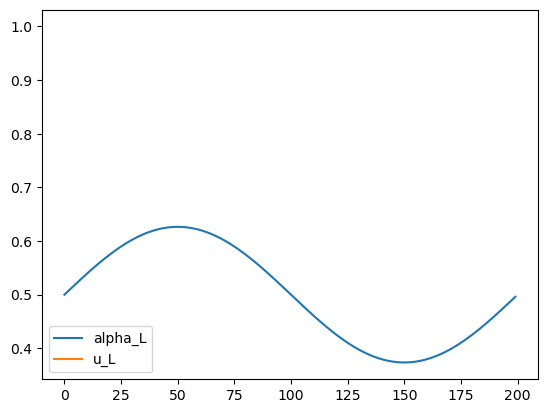

In [312]:
import matplotlib.pyplot as plt

alpha_L = [cell.A_L / (cell.A_L + cell.A_G) for cell in mesh.cells]
u_L = [cell.u_L for cell in mesh.cells]
plt.plot(alpha_L, label="alpha_L")
plt.plot(u_L, label="u_L")
plt.legend()
plt.show()

In [307]:
u_L

[1.0,
 1.0987316382715866,
 1.0993691908495868,
 1.099031294230022,
 1.098696577258453,
 1.0983684991356273,
 1.0980471212817264,
 1.0977325914087723,
 1.0974250452571714,
 1.0971246037828362,
 1.0968313737941013,
 1.0965454486750064,
 1.096266909114566,
 1.0959958238378433,
 1.0957322503363167,
 1.0954762355951317,
 1.0952278168150953,
 1.0949870221271918,
 1.0947538712977325,
 1.0945283764221192,
 1.094310542605398,
 1.0941003686278503,
 1.0938978475937238,
 1.093702967561539,
 1.0935157121542007,
 1.093336061147365,
 1.0931639910344613,
 1.0929994755668646,
 1.0928424862679367,
 1.092692992919554,
 1.0925509640200617,
 1.0924163672126472,
 1.0922891696834722,
 1.09216933852889,
 1.0920568410916336,
 1.0919516452658196,
 1.0918537197712301,
 1.091763034397361,
 1.0916795602181555,
 1.0916032697787779,
 1.0915341372557434,
 1.0914721385923252,
 1.0914172516111507,
 1.0913694561061664,
 1.0913287339162185,
 1.091295068982524,
 1.0912684473924108,
 1.0912488574112964,
 1.091236289505137